Meaghan Woody

UP 213

Spring 2025

Data cleaning

- HOLC Redlining
- LA Census maps

### 1. Access Census Data using the Census Bureau API

Request the following ACS variables to map SNAP Underenrollment:

https://api.census.gov/data/2015/acs/acs5/variables.html

Total Population:

    B22003_001E = (TOTAL POP) RECEIPT OF FOOD STAMPS/SNAP IN THE PAST 12 MONTHS BY POVERTY STATUS IN THE PAST 12 MONTHS FOR HOUSEHOLDS	

    B17017_002E = (TOTAL POP) POVERTY STATUS IN THE PAST 12 MONTHS BY HOUSEHOLD TYPE BY AGE OF HOUSEHOLDER	

Received food stamps:

    B22003_002E = Estimate!!Total!!Household received Food Stamps/SNAP in the past 12 months		
    
    B22003_003E = Estimate!!Total!!Household received Food Stamps/SNAP in the past 12 months!!Income in the past 12 months below poverty level	


Did not receive food stamps:

    B22003_005E = Estimate!!Total!!Household did not receive Food Stamps/SNAP in the past 12 months
    
    B22003_006E = Estimate!!Total!!Household did not receive Food Stamps/SNAP in the past 12 months!!Income in the past 12 months below poverty level
    


In [5]:
import json
import requests
import pandas as pd

r = requests.get('https://api.census.gov/data/2023/acs/acs5?get=B22003_001E&B17017_002E&B22003_002E&B22003_003E&B22003_005E&B22003_006E&for=tract:*&in=state:06%20county:037')
censusdata = r.json()
census_snap = pd.DataFrame(censusdata[1:], columns=censusdata[0])
census_snap.head()

,B22003_001E,B17017_002E,B22003_002E,B22003_003E,B22003_005E,B22003_006E,state,county,tract
0,1558,247,283,103,1275,144,06,037,101110
1,1407,69,160,42,1247,27,06,037,101122
2,1357,215,324,149,1033,66,06,037,101220
3,1483,275,433,116,1050,159,06,037,101221
4,948,287,284,169,664,118,06,037,101222


In [6]:
# Rename the variables 
census_snap = census_snap.rename(columns={
    'B22003_001E': 'total_hh',
    'B17017_002E': 'total_pov',
    'B22003_002E': 'snap_tot_hh',
    'B22003_003E': 'snap_pov_hh',
    'B22003_005E': 'nosnap_tot_hh',
    'B22003_006E': 'nosnap_pov_hh'
})

census_snap.head()

,total_hh,total_pov,snap_tot_hh,snap_pov_hh,nosnap_tot_hh,nosnap_pov_hh,state,county,tract
0,1558,247,283,103,1275,144,06,037,101110
1,1407,69,160,42,1247,27,06,037,101122
2,1357,215,324,149,1033,66,06,037,101220
3,1483,275,433,116,1050,159,06,037,101221
4,948,287,284,169,664,118,06,037,101222


### Calculate the following:

Observed SNAP Participation Rate: % of eligible households receiving SNAP benefits

    obs_snap = snap_tot_hh / total_pov * 100%

SNAP-Eligible But Not Enrolled (EBNE): percentage of households below the federal poverty level, who are not enrolled in the SNAP program. This is a conservative proxy for the percentage of eligible but not enrolled (EBNE) households by census tract, because, in CA, households can make less than or equal to 130% of the federal poverty level and still qualify for the SNAP program

    ebne_snap = nosnap_pov_hh / total_pov * 100%

In [8]:
census_snap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   total_hh       2498 non-null   object
 1   total_pov      2498 non-null   object
 2   snap_tot_hh    2498 non-null   object
 3   snap_pov_hh    2498 non-null   object
 4   nosnap_tot_hh  2498 non-null   object
 5   nosnap_pov_hh  2498 non-null   object
 6   state          2498 non-null   object
 7   county         2498 non-null   object
 8   tract          2498 non-null   object
dtypes: object(9)
memory usage: 175.8+ KB


In [9]:
# Convert variables to float in variable calculations

# Calculate observed SNAP participation: % of poverty households that received SNAP
census_snap['obs_snap'] = (census_snap.snap_pov_hh.astype(float) / census_snap.total_pov.astype(float)) * 100

# Calculate EBNE: % of poverty households not enrolled in SNAP
census_snap['ebne_snap'] = (census_snap.nosnap_pov_hh.astype(float) / census_snap.total_pov.astype(float)) * 100

# View new vars
census_snap.head()

,total_hh,total_pov,snap_tot_hh,snap_pov_hh,nosnap_tot_hh,nosnap_pov_hh,state,county,tract,obs_snap,ebne_snap
0,1558,247,283,103,1275,144,06,037,101110,41.700405,58.299595
1,1407,69,160,42,1247,27,06,037,101122,60.869565,39.130435
2,1357,215,324,149,1033,66,06,037,101220,69.302326,30.697674
3,1483,275,433,116,1050,159,06,037,101221,42.181818,57.818182
4,948,287,284,169,664,118,06,037,101222,58.885017,41.114983


<Axes: >

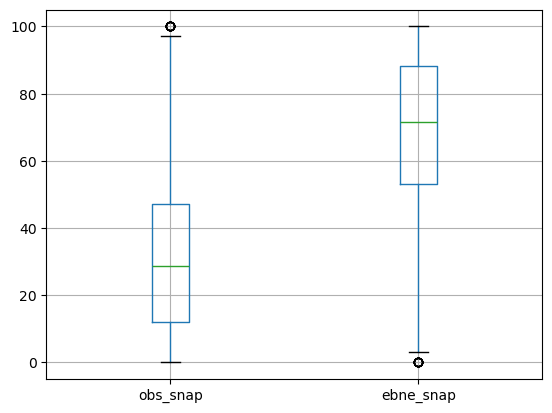

In [10]:
# Check the distribution of these variables
census_snap[['obs_snap', 'ebne_snap']].boxplot()

## 2. Load in Shapefiles for Los Angeles County

Data obtained from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

In [13]:
import geopandas as gpd

# Load LA County tract shapefile
tracts = gpd.read_file('/Users/markwoody/Desktop/UP 213/UP213Final/final/tl_2020_06_tract_LACounty.zip')
print(tracts.columns)
tracts.head(5)

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,06,037,262601,06037262601,2626.01,Census Tract 2626.01,G5020,S,3620351.0,0.0,+34.0738344,-118.5557893,0.108596,0.000354,"POLYGON ((-118.57556 34.08019, -118.57497 34.0..."
1,06,037,300100,06037300100,3001,Census Tract 3001,G5020,S,4591342.0,18657.0,+34.2442558,-118.2325716,0.094693,0.000451,"POLYGON ((-118.2486 34.23881, -118.24858 34.23..."
2,06,037,300501,06037300501,3005.01,Census Tract 3005.01,G5020,S,1260255.0,0.0,+34.2206887,-118.2400494,0.061435,0.000123,"POLYGON ((-118.24875 34.22249, -118.24875 34.2..."
3,06,037,310701,06037310701,3107.01,Census Tract 3107.01,G5020,S,515339.0,0.0,+34.1853923,-118.3128440,0.036201,0.000050,"POLYGON ((-118.31952 34.18495, -118.31915 34.1..."
4,06,037,300200,06037300200,3002,Census Tract 3002,G5020,S,1943986.0,10136.0,+34.2283768,-118.2386852,0.067506,0.000191,"POLYGON ((-118.24864 34.23324, -118.24863 34.2..."


In [14]:
# Create GEOID in both datasets
census_snap['GEOID'] = census_snap['state'] + census_snap['county'] + census_snap['tract']

# Set GEOID as index
tracts = tracts.set_index('GEOID')
census_snap = census_snap.set_index('GEOID')

# Join geometry from tracts into full census_snap
snap_tracts = census_snap.join(tracts[['geometry']], how='inner')
snap_tracts.head(5)

,total_hh,total_pov,snap_tot_hh,snap_pov_hh,nosnap_tot_hh,nosnap_pov_hh,state,county,tract,obs_snap,ebne_snap,geometry
GEOID,,,,,,,,,,,,
06037101110,1558,247,283,103,1275,144,06,037,101110,41.700405,58.299595,"POLYGON ((-118.30229 34.2587, -118.30091 34.25..."
06037101122,1407,69,160,42,1247,27,06,037,101122,60.869565,39.130435,"POLYGON ((-118.30334 34.27371, -118.3033 34.27..."
06037101220,1357,215,324,149,1033,66,06,037,101220,69.302326,30.697674,"POLYGON ((-118.28593 34.25227, -118.28592 34.2..."
06037101221,1483,275,433,116,1050,159,06,037,101221,42.181818,57.818182,"POLYGON ((-118.29945 34.25598, -118.29792 34.2..."
06037101222,948,287,284,169,664,118,06,037,101222,58.885017,41.114983,"POLYGON ((-118.29434 34.25233, -118.29318 34.2..."


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx

fig, ax = plt.subplots(figsize=(10,10))

# project to EPSG: 3857 to match the basemap
# use the markersize keyword to make the points smaller
snap_tracts.to_crs('EPSG:4326').plot(
            column='obs_snap',
            ax=ax,
            markersize=20,  # Consistent size
            cmap='Greens',
            legend=True,
            legend_kwds={'label': "SNAP",
            'shrink': 0.5,  # make the color bar shorter
            'aspect': 20} # controls width — higher = skinnier                         
                         )

# add a basemap
ctx.add_basemap(ax=ax, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)

# drop the tick labels
ax.set_xticks([])
ax.set_yticks([])

# add a title
ax.set_title('Observed SNAP Rate in Los Angeles County, ACS 2023')

AttributeError: 'DataFrame' object has no attribute 'to_crs'

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

snap_tracts.to_crs('EPSG:4326').plot(
            column='ebne_snap',
            ax=ax,
            markersize=20,  # Consistent size
            cmap='Oranges',
            legend=True,
            legend_kwds={'label': "ENBE",
            'shrink': 0.5,  # make the color bar shorter
            'aspect': 20} # controls width — higher = skinnier                         
                         )

# add a basemap
ctx.add_basemap(ax=ax, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)

# drop the tick labels
ax.set_xticks([])
ax.set_yticks([])

# add a title
ax.set_title('Eligible but not Enrolled in SNAP Rate in Los Angeles County, ACS 2023')

In [ ]:
plt.show()

### 3. Aggregate to Service Planning Areas

Downloaded Los Angeles County Service Planning Areas (SPAs) 2022 from https://egis-lacounty.hub.arcgis.com/datasets/lacounty::service-planning-areas-2022-view/about

In [ ]:
spas = gpd.read_file('/Users/markwoody/Desktop/UP 213/UP213Final/final/Service_Planning_Areas_2022_view_8558881845522833049.zip')
spas = spas.to_crs(epsg=4326)
spas.head(5)

In [ ]:
# Step 1: Project to a local CRS for accurate geometry operations
census_projected = census_snap.to_crs(epsg=2229)

# Step 2: Calculate centroids in the projected CRS
census_projected['centroid'] = census_projected.geometry.centroid

# Step 3: Make a new GeoDataFrame with centroids as geometry
census_centroids = census_projected.set_geometry('centroid')

# Step 4: Reproject back to match SPA CRS (EPSG:4326)
census_centroids = census_centroids.to_crs(epsg=4326)

# Step 5: Create empty SPA column
census_centroids['SPA'] = None

# Step 6: Assign SPA ID based on whether centroid falls within each SPA polygon
for spa_id, spa_row in spas.iterrows():
    mask = census_centroids.geometry.within(spa_row.geometry)
    census_centroids.loc[mask, 'SPA'] = spa_id

census_centroids.head(5)